<a href="https://colab.research.google.com/github/TINF-DeepfakeEvaluierung/Evaluation-von-Methoden-zur-Erkennung-von-Deepfakes/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [ ]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 656 (delta 101), reused 87 (delta 83), pack-reused 537
Receiving objects: 100% (656/656), 99.64 MiB | 12.32 MiB/s, done.
Resolving deltas: 100% (341/341), done.
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cac

In [ ]:
import torch
from torch.utils.model_zoo import load_url
from scipy.special import expit
from sklearn.preprocessing import normalize
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import shutil
import os
import sys
from itertools import islice

sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

In [ ]:
# Connect Google Cloud
# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "deepfake_detection_datasets"  # or a location like "my-bucket/path/to/mount"
local_path = f"/content/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  31353      0 --:--:-- --:--:-- --:--:-- 31654
OK
48 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 48 not upgraded.
Need to get 10.4 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../gcsfuse_2.0.1_amd64.deb ...
Unpacking gcsfuse (2.0.1) ...
Setting up g

## Parameters

In [ ]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'FFPP'

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

## Initialization

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_FFPP_bestval-b0c9e9522a7143cf119843e910234be5e30f77dc527b1b427cdffa5ce3bdbc25.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_FFPP_bestval-b0c9e9522a7143cf119843e910234be5e30f77dc527b1b427cdffa5ce3bdbc25.pth
100%|██████████| 33.9M/33.9M [00:03<00:00, 11.5MB/s]


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

## Detection Method

In [ ]:
def detect_deepfake(deepfake_folder):
  scores = np.array([]);

  for deepfake in tqdm(os.listdir(deepfake_folder)):
    vid_path = os.path.join(deepfake_folder, deepfake)
    vid = face_extractor.process_video(vid_path)

    # For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
    faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )

    with torch.no_grad():
        faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()

    scores = np.append(scores, expit(faces_pred.mean()))
    # print('Average score for {} video: {:.4f}'.format(deepfake, expit(faces_pred.mean())))
  return scores

## TIMIT

### Prepare TIMIT Dataset

In [ ]:
def move_timit_deepfakes(source_dir, output_dir):
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
  else:
    # Wenns schon existiert wurde schon kopiert
    return

  for folder in os.listdir(source_dir):
    path = os.path.join(source_dir, folder)
    if not os.path.isdir(path):
      continue
    for filename in os.listdir(path):
      if filename.endswith(".avi"):
        source_file = os.path.join(path, filename)
        dest_file = os.path.join(output_dir, filename)

        shutil.move(source_file, dest_file)

In [ ]:
high_output_dir = "/content/deepfake_detection_datasets/DeepfakeTIMIT/deepfakes_higher_quality"
high_source_dir = "/content/deepfake_detection_datasets/DeepfakeTIMIT/higher_quality"
move_timit_deepfakes(high_source_dir, high_output_dir)

low_output_dir = "/content/deepfake_detection_datasets/DeepfakeTIMIT/deepfakes_lower_quality"
low_source_dir = "/content/deepfake_detection_datasets/DeepfakeTIMIT/lower_quality"
move_timit_deepfakes(low_source_dir, low_output_dir)

### Detect TIMIT Deepfakes

In [ ]:
# High Quality
dataset = "TIMIT (hohe Auflösung)"
high_output_dir = "/content/deepfake_detection_datasets/DeepfakeTIMIT/deepfakes_higher_quality"


# score_fake = detect_deepfake(high_output_dir)
score_real = np.array([])

In [ ]:
# High Quality
dataset = "TIMIT (niedrige Auflösung)"
high_output_dir = "/content/deepfake_detection_datasets/DeepfakeTIMIT/deepfakes_higher_quality"


score_fake = detect_deepfake(high_output_dir)
score_real = np.array([])

## CELEB-DF

In [ ]:
real_celeb_dir = "/content/deepfake_detection_datasets/Celeb-DF/Celeb-real"
fake_celeb_dir = "/content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis"
dataset = "CelebDF"

### Prepare CELEB-DF Dataset

In [ ]:
def move_celeb_deepfakes(source_dir, output_dir):
  for filename in tqdm(os.listdir(source_dir)):
    if filename.endswith(".mp4"):
      source_file = os.path.join(source_dir, filename)
      dest_file = os.path.join(output_dir, filename)

      shutil.move(source_file, dest_file)

In [ ]:
real_celeb_youtube_dir = "/content/deepfake_detection_datasets/Celeb-DF/YouTube-real"
move_celeb_deepfakes(real_celeb_youtube_dir, real_celeb_dir)

100%|██████████| 300/300 [00:01<00:00, 296.35it/s]


### Detect Deepfakes CELEB-DF

In [ ]:
def detect_celeb_deepfake(deepfake_folder, num_videos=890):
  scores = np.array([]);

  for deepfake in tqdm(islice(os.listdir(deepfake_folder), num_videos), total=num_videos):
    vid_path = os.path.join(deepfake_folder, deepfake)
    vid = face_extractor.process_video(vid_path)

    # For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
    faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )

    with torch.no_grad():
        faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()

    scores = np.append(scores, expit(faces_pred.mean()))
    # print('Average score for {} video: {:.4f}'.format(deepfake, expit(faces_pred.mean())))
  return scores

In [ ]:
score_real = detect_celeb_deepfake(real_celeb_dir)
score_fake = detect_celeb_deepfake(fake_celeb_dir)

### Confusion Matrix erstellen

In [ ]:
# Manuelle Datenerfassung
# B4 DFDC
net_model = 'EfficientNetB4'
train_db = 'DFDC'

TP = 4303 # True Positives  => Fake Videos als fake Klassifiziert
FN = 1336 # False Negatives => Fake Videos als echt Klassifiziert
FP = 217 # False Positives => Echt Videos als fake Klassifiziert
TN = 654 # True Negatives  => Echt Videos als echt Klassifiziert

In [ ]:
# B4ST DFDC
net_model = 'EfficientNetB4ST'
train_db = 'DFDC'

TP = 4199
FN = 1440
FP = 249
TN = 641

In [ ]:
# AutoAttB4 DFDC
net_model = 'EfficientNetAutoAttB4'
train_db = 'DFDC'

TP = 4189
FN = 1450
FP = 213
TN = 677

In [ ]:
# AutoAttB4ST DFDC
net_model = 'EfficientNetAutoAttB4ST'
train_db = 'DFDC'

TP = 3781
FN = 1858
FP = 249
TN = 641

In [ ]:
# B4 FFPP
net_model = 'EfficientNetB4'
train_db = 'FFPP'

TP = 3455
FN = 2184
FP = 180
TN = 710

## VASA-1
[Webseite](https://https://www.microsoft.com/en-us/research/project/vasa-1/)

[Paper](https://arxiv.org/pdf/2404.10667.pdf)

In [ ]:
vasa_dir = "/content/deepfake_detection_datasets/VASA-1"
dataset = "VASA-1"

score_fake = detect_deepfake(vasa_dir)
score_real = np.array([])

print(f"Fake Scores: {score_fake}")

100%|██████████| 15/15 [00:20<00:00,  1.35s/it]

Fake Scores: [0.00847442 0.00218733 0.00347676 0.00249026 0.01739395 0.00796419
 0.01123404 0.00603204 0.01166494 0.00294177 0.00552632 0.004751
 0.00488503 0.00153002 0.00370283]


## DFDC

In [ ]:
dfdc_dir = "/content/deepfake_detection_datasets/DFDC/train_sample_videos"
dataset = "DFDC"

In [ ]:
def detect_dfdc_deepfake(deepfake_folder):
  metadata_file = deepfake_folder + "/metadata.json"

  with open(metadata_file, 'r') as file:
    metadata = json.load(file)

  scores_real = np.array([]);
  scores_fake = np.array([]);

  for deepfake, properties in tqdm(metadata.items()):
    vid_path = os.path.join(deepfake_folder, deepfake)
    vid = face_extractor.process_video(vid_path)

    # For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
    faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )

    with torch.no_grad():
        faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()

    if properties['label'] == "FAKE":
      scores_fake = np.append(scores_fake, expit(faces_pred.mean()))
    else:
      scores_real = np.append(scores_real, expit(faces_pred.mean()))

  return scores_fake, scores_real

In [ ]:
score_fake, score_real = detect_dfdc_deepfake(dfdc_dir)

100%|██████████| 400/400 [1:08:16<00:00, 10.24s/it]


## FF++

In [ ]:
ffpp_dir = "/content/deepfake_detection_datasets/FFPP/"
dataset = "FaceForensics++"

In [ ]:
def detect_ffpp_deepfakes(ffpp_dir):
    scores_real = np.array([])
    scores_fake = np.array([])

    for root, _, files in os.walk(ffpp_dir):
      files_bar = tqdm(files)

      for file in files_bar:
        if file.endswith('.mp4'):
          vid_path = os.path.join(root, file)
          vid = face_extractor.process_video(vid_path)

          # Check if the file is in the original_sequences or manipulated_sequences directory and update tqdm description
          rel_path = os.path.relpath(vid_path, ffpp_dir)
          path_parts = rel_path.split(os.sep)
          files_bar.set_description(f"{path_parts[0]}/{path_parts[1]}")

          # For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
          faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )

          with torch.no_grad():
            faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()

          if path_parts[0] == 'manipulated_sequences':
            scores_fake = np.append(scores_fake, expit(faces_pred.mean()))
          else:
            scores_real = np.append(scores_real, expit(faces_pred.mean()))

    return scores_fake, scores_real

In [ ]:
score_fake, score_real = detect_ffpp_deepfakes(ffpp_dir)

100%|██████████| 4/4 [00:00<00:00, 13785.72it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 316551.25it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [0

## FakeAVCeleb

In [ ]:
fakeavceleb_metadata = "/content/deepfake_detection_datasets/FakeAVCeleb/meta_data.csv"
dataset = "FakeAVCeleb"

In [ ]:
def detect_fakeAVCeleb_deepfake(metadata_file):
  metadata = pd.read_csv(metadata_file)

  scores_real = np.array([]);
  scores_fake = np.array([]);

  # Filter for 'RealVideo-RealAudio' category
  real_videos = metadata[metadata['type'] == 'RealVideo-RealAudio']
  sampled_reals = real_videos.groupby(['race', 'gender']).apply(
        lambda x: x.sample(n=50, replace=False) if len(x) >= 50 else x).reset_index(drop=True)

  # Filter for 'FakeVideo-RealAudio' category and sample
  fake_videos = metadata[metadata['type'] == 'FakeVideo-RealAudio']
  sampled_fakes = fake_videos.groupby(['race', 'gender']).apply(
        lambda x: x.sample(n=50, replace=False) if len(x) >= 50 else x).reset_index(drop=True)

  # Concatenate real and sampled fake videos
  final_metadata = pd.concat([sampled_reals, sampled_fakes]).reset_index(drop=True)
  for index, properties in tqdm(final_metadata.iterrows(), total=len(final_metadata.index)):
    vid_path = os.path.join("/content/deepfake_detection_datasets/", properties['Unnamed: 9'], properties['path'])
    vid = face_extractor.process_video(vid_path)

    # For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
    faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )

    with torch.no_grad():
        faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()

    if properties['method'] == "real":
      scores_real = np.append(scores_real, expit(faces_pred.mean()))
    else:
      scores_fake = np.append(scores_fake, expit(faces_pred.mean()))

  return scores_fake, scores_real

In [ ]:
score_fake, score_real = detect_fakeAVCeleb_deepfake(fakeavceleb_metadata)

100%|██████████| 1000/1000 [30:43<00:00,  1.84s/it]


## Create Diagrams

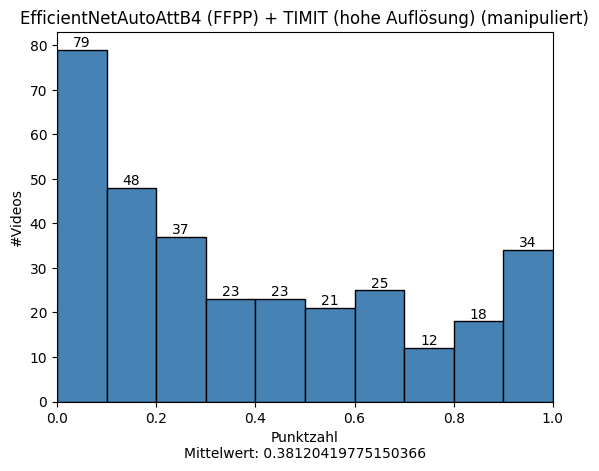

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

# _, _, bars = plt.hist(score_real, range=(0,1), color='steelblue', edgecolor='black')
# plt.title(f'{net_model} ({train_db}) + {dataset} (echt)')
# plt.xlabel(f'Punktzahl\nMittelwert: {score_real.mean()}')
# plt.bar_label(bars)
# plt.xlim(0, 1)
# plt.ylabel('#Videos')
# plt.show()

_, _, bars = plt.hist(score_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'{net_model} ({train_db}) + {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {score_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

In [ ]:
# Getting Data
TP = np.sum(score_fake > 0.6) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(score_fake < 0.6) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(score_real > 0.4) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(score_real < 0.4) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

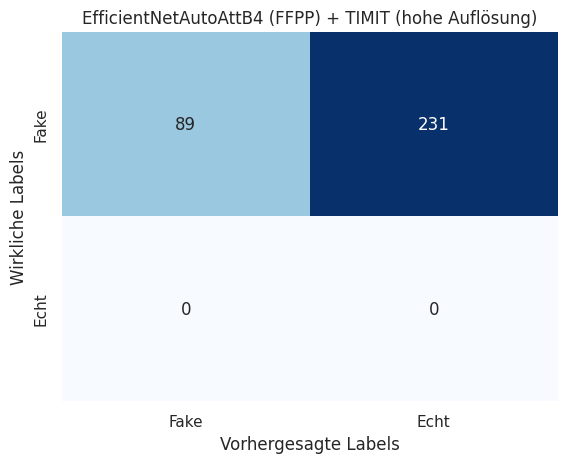

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'{net_model} ({train_db}) + {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

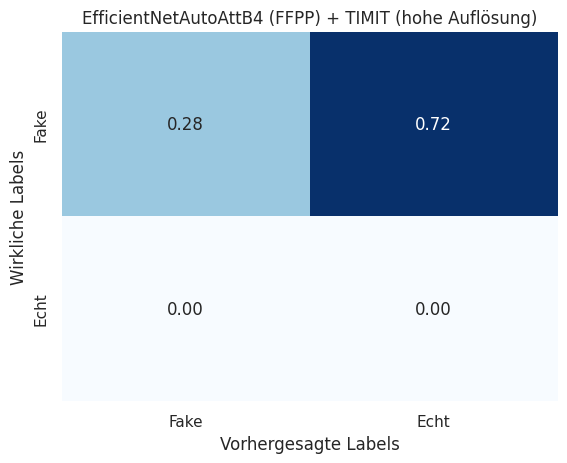

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'{net_model} ({train_db}) + {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()